## Online banking fraud detection using natural language processing techniques

**Team 9:**

- Latif Masud
- ​Wesley Mitchell
- Gerald Wagner​

**Course:** AI 574 – Natural Language Processing (Spring 2025)

### Problem Statement
* This project aims to identify fraudulent activity in online banking transactions using Natural Language Processing techniques. Online banking activity can be monitored by the webpages or API endpoints a user interacts with throughout their entire session history. With this sequence of user actions, a binary classification can be trained such that it labels the activity as valid or fraudulent; if fraudulent, remediation steps could then be implemented such as denying the transaction. With online banking a staple of people every day financial lives and 100's of millions of dollars transacted daily, identifying fraudulent activity is of upmost importance to prevent unnecessary monetary losses for both individuals and financial institutions.
    
* **Keywords:** Online banking, fraud, fraud detection, financial industry 

### Data Collection

* Source(url): https://github.com/pboulieris/FraudNLP/blob/master/Fraud%20Detection%20with%20Natural%20Language%20Processing.rar
* Short Description: The data set of 105,303 online banking transactions with 9 transaction characteristics:
    * Action time mean: the average time between actions in a transaction
    * Action time std: the standard deviation of the time between actions
    * log(amount): the natural logarithm of the transaction amount
    * Transaction Type: a string indicating whether the transaction is fraudulent or not
    * time_to_first_action: the time between the start of the transaction and the first action taken
    * actions_str: a string containing the names of all actions taken in the transaction
    * total_time_to_transaction: the total time elapsed from the start of the transaction to its completion

* Keywords: bank transactions, user actions, API endpoints, webpage urls, dollar amount

### Required packages

* the following packages are required to run this notebook:
    * pandas
    * scikit-learn
    * nltk
    * matplotlib

Install by creating and activating a virtual environment, then installing via the pip command:

!pip install -r requirements.txt

In [ ]:
!pip install -r requirements.txt

### Imports

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
from nltk import FreqDist
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from wordcloud import WordCloud

### Load the data

In [13]:
# online banking transaction data
path = Path('./data/Fraud Detection with Natural Language Processing.pkl')
df = pd.read_pickle(path)

In [14]:
# vocabulary of API calls
path_vocab = Path('./data/vocab.csv')
df_vocab = pd.read_csv(path_vocab)

### Exploratory data analysis (EDA)

In [6]:
df.shape

(105303, 9)

In [7]:
df.head(10)

,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud
0,"[[2], [23], [6], [7], [14], [25], [28], [6], [...","[0, 47000.0, 640000.0, 6000.0, 54000.0, 10000....",203,15,1.000000,1.000000,1.000000,1.0,0
1,"[[22], [27], [24], [1], [1268], [1269], [1267]...","[0, 33204.0, 215636.0, 443415.0, 72586.0, 3424...",203,13,1.000000,1.000000,0.500000,1.0,0
2,"[[22], [24], [27], [1], [1268], [1269], [1267]...","[0, 25459.0, 46236.0, 428626.0, 42785.0, 74158...",359,310,1.000000,0.333333,0.333333,1.0,0
3,"[[22], [1], [29], [22], [26], [2], [23], [25],...","[0, 440927.0, 5785.0, 46875.0, 968650.0, 31175...",250,350,1.000000,0.500000,0.500000,1.0,0
4,"[[22], [24], [27], [72], [1269], [1268], [1267...","[0, 93894.0, 46810.0, 548388.0, 132548.0, 3784...",203,350,1.000000,0.600000,0.400000,1.0,0
5,"[[22], [24], [27], [23], [2], [1269], [1269], ...","[0, 921997.0, 47386.0, 963970.0, 9522.0, 44359...",593,2000,1.000000,0.666667,0.166667,1.0,1
6,"[[22], [47], [24], [27], [41], [2], [23], [6],...","[0, 48869.0, 843763.0, 138682.0, 203156.0, 944...",124,80,0.142857,0.142857,0.285714,1.0,0
7,"[[37], [37]]","[0, 941710.0]",656,80,0.250000,0.250000,0.375000,1.0,0
8,"[[10], [56], [12], [121], [13], [52], [19], [8...","[0, 437000.0, 93000.0, 860000.0, 14000.0, 1000...",595,135,1.000000,1.000000,1.000000,1.0,0
9,"[[25], [4], [5], [24], [27], [41], [45], [4], ...","[0, 31238.0, 141391.0, 5510.0, 10000.0, 280000...",468,154,1.000000,1.000000,1.000000,1.0,0


In [8]:
df.describe()

,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud
count,105303.000000,1.053030e+05,105303.000000,105303.000000,105303.000000,105303.000000,105303.000000
mean,655.664236,4.687915e+02,0.706309,0.259218,0.406677,0.896871,0.000959
std,1367.867413,7.095939e+03,0.349859,0.307056,0.305293,0.218759,0.030955
min,15.000000,0.000000e+00,0.000960,0.000946,0.000954,0.002433,0.000000
25%,359.000000,3.700000e+01,0.400000,0.047619,0.142857,0.945455,0.000000
50%,623.000000,1.000000e+02,0.910256,0.120370,0.333333,1.000000,0.000000
75%,795.000000,2.400000e+02,1.000000,0.333333,0.641026,1.000000,0.000000
max,127578.000000,1.500000e+06,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.dtypes

actions              object
times                object
execution_time        int64
Amount                int32
device_freq         float64
ip_freq             float64
beneficiary_freq    float64
application_freq    float64
is_fraud              int64
dtype: object

In [10]:
df.groupby('is_fraud').describe()

execution_time                                                      \
                  count        mean          std   min    25%    50%    75%   
is_fraud                                                                      
0              105202.0  655.652336  1368.497015  15.0  359.0  623.0  795.0   
1                 101.0  668.059406   277.834621  93.0  453.0  656.0  812.0   

                      Amount                ... beneficiary_freq       \
               max     count          mean  ...              75%  max   
is_fraud                                    ...                         
0         127578.0  105202.0    457.337180  ...         0.641509  1.0   
1           1937.0     101.0  12399.673267  ...         0.166667  1.0   

         application_freq                                                     \
                    count      mean       std       min       25%   50%  75%   
is_fraud                                                                       
0                105202.0  0.897077  0.218437  0.002433  0.945946  1.00  1.0   
1                   101.0  0.682153  0.387336  0.005291  0.279503  0.95  1.0   

               
          max  
is_fraud       
0         1.0  
1         1.0  

[2 rows x 48 columns]

In [11]:
df_vocab.head()

,Name
0,/ACCOUNTS/ACCOUNTS_FULL_EXCHANGE
1,/PROFILE/USERPROFILE
2,/P2PREGISTRATION/ASKMEMBER
3,/CARDS/FETCHCARDS
4,/ACCOUNTS/ACCOUNTS_FULL


In [12]:
df_vocab.shape

(1916, 1)

In [13]:
df_vocab.describe()

,Name
count,1916
unique,1916
top,/API/WHITELIST/PRODUCTS_LIST
freq,1


EDA Summary

- the transaction dataset contains 105303 online banking transactions
- of the 105303 transactions, 105202 are valid while only 101 are fraudulent
    - this is a severe class imbalance that will have to be handled in the neural network architecture
- there are 9 attributes for each banking transaction:
    - a label for trasactions that are valid or fraudulent (0 or 1 respectively)
    - list of user actions encoded as a list of integers which corresponds to the vocabulary dataframe
    - list of times in ms for each user action to occur
    - the total elapsed time of the transaction in ms
    - Recency, Frequency, and Monetary features:
        - the transaction amount in log(Euros)
        - the device characteristics
        - the IP address of the user
        - the beneficiary's frequency of conducting a transaction
        - the applications used for the transaction (i.e., Android or iOS)
- there also exists a vocabulary dataset which contains a list of API endpoints/webpage urls which a user can access
    - these are used to translate the encoded user action column of the transaction dataset back to the original url's
    - there are 1916 total endpoints/url's, all of which are unique
    - the index of the dataframe corresponds to the id value used in the user action list from the transaction dataframe

### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions

In [15]:
# dictionary mapping ids in transaction data to vocabulary
vocab = df_vocab['Name'].to_list()

vocab_sentences = []
for endpoint in vocab:
    sentence = endpoint.replace('/', ' ').lstrip().lower() + ' .'
    vocab_sentences.append(sentence)

id_to_action = {i:a for i, a in enumerate(vocab_sentences)}

In [16]:
# convert the tokenized user actions during online banking to API endpoint calls
actions_raw = df['actions'].to_list()

actions = []
for action in actions_raw:

    action_str = (action.replace('[', '')
           .replace(']', '')
           .replace(' ', '')
           .split(','))
    
    action_ids = []
    for id in action_str:
        if id:
            
            action_ids.append(id_to_action[int(id)])

    actions.append(' '.join(action_ids))

<Axes: xlabel='Samples', ylabel='Counts'>

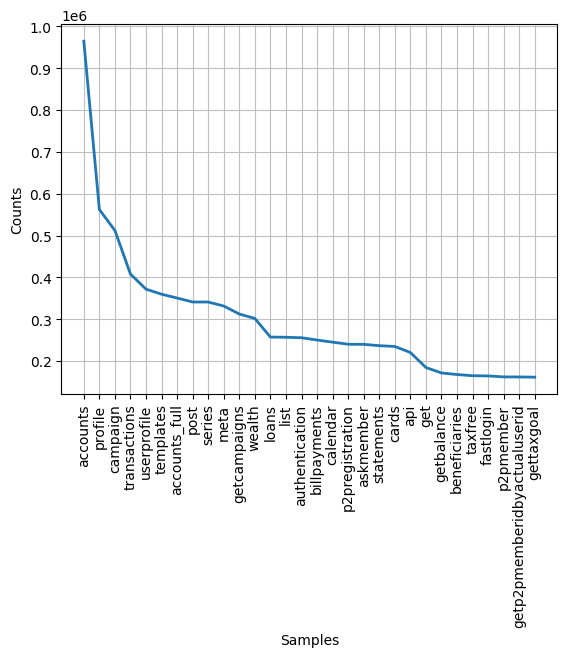

In [17]:
# plot the words to see most frequent
word_list = ' '.join(actions).replace(' . ', ' ').split()
fdist = FreqDist(word_list[2:])
fdist.plot(30)

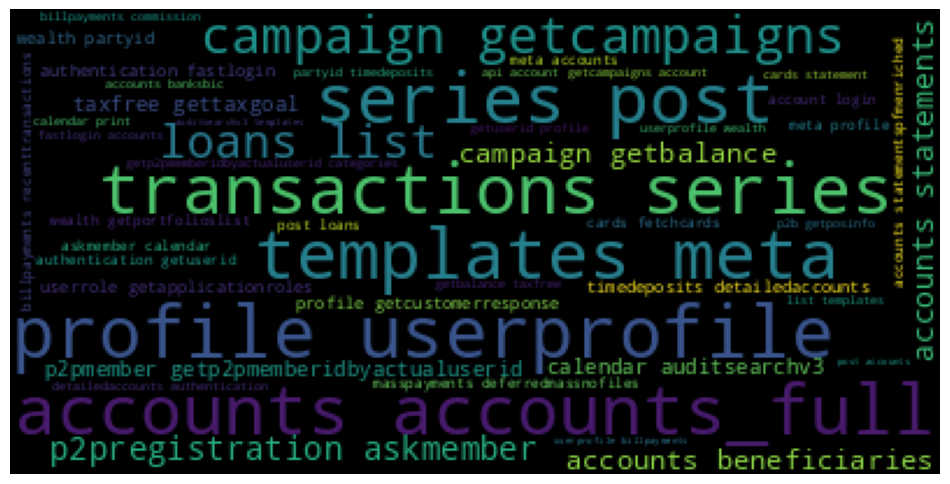

In [18]:
# create wordcloud to visualize popular words
wordcloud = WordCloud().generate(' '.join(word_list))

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
sequence_length = [len(s.split()) for s in actions]

Text(0, 0.5, 'Number of Sentences')

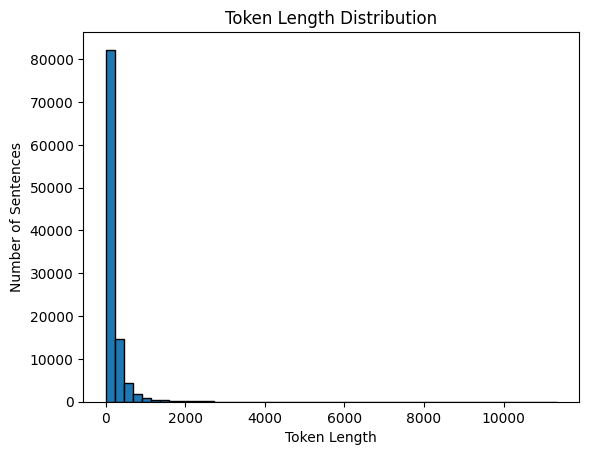

In [20]:
fig = plt.hist(sequence_length, bins = 50, edgecolor = 'black')
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Number of Sentences')

In [21]:
# create an array of labels
labels = df['is_fraud'].to_list()

print(f'there are {sum(labels)} fraudulent transactions')
print(f'which is only {sum(labels)/len(labels)*100:0.2f}% of the total transactions')

there are 101 fraudulent transactions
which is only 0.10% of the total transactions


In [22]:
# seperate the data into training and testing datasets
# enable the stratify option to ensure there are proportional amounts of fraudulent transactions in the training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(actions, labels, test_size=0.2, shuffle=True, stratify=labels)

In [23]:
print(sum(y_train))
print(sum(y_test))

81
20


### Natural Language Processing Model Development

#### Methodology

To identify fraudulent online banking transactions, several models were developed and compared to determine the best performing approach. This included fine-tuning DistilBERT and DeepSeek R1. 



The NLP models used in our project were:
 * DistilBERT
    * This is a pretrained model created by distilling BERT. It is smaller and faster than BERT, and requires less compute to train. This is great for the large dataset contained in FraudNLP. 
 
 * DeepSeek R1
    * Description
 
 * Ensemble method
     * Description 
 
* **Keywords:** natural language processing, binary classification, fraud prediction, class imbalance, fine tuning, pretrained models

## Deepseek R1

Load in the necessary dependencies:

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### Define the dataset
We want to train on uniform length of data per each index of data, so we set `padding` and `max_length` to be the same. We also turn on `truncation`. 

In [ ]:
class FraudDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

### Define the model
Lightning framework encompasses training, validation and optimzations all into a single class.

We'll use a learning rate of `2e-5` because this is very common for large language models to guard against `catastrophic forgetting` [TODO: Reference]. 
We'll setup the fine tuning process to add in a new linear layer at the end that takes the final hidden representation and maps it to logits for binary classification.
We'll use `CrossEntropyLoss` as the loss function because we are doing a classification problem that outputs two classes and `CrossEntropyLoss` has shown to be a good industry standard for loss functions for classiciation problems (TODO: reference)
For PyTorch Lightining, we also have to define a `configure_optimizers` method. For this DeepSeek model, we are using the `AdamW` optimizer because it is also a common optimier instead of things like SGD and RMS (todo: find refernces)

In [ ]:
from transformers import AutoModel

class DeepSeekClassifier(pl.LightningModule):
    def __init__(self, model_name, lr=2e-5, n_classes=2):
        super().__init__()
        self.save_hyperparameters()
        hf_token = os.getenv("HF_TOKEN")
        # self.base_model = AutoModel.from_pretrained(
        #     model_name,
        #     torch_dtype=torch.float16,
        #     trust_remote_code=True,
        #     token=hf_token,
        #     device_map="auto",
        #     low_cpu_mem_usage=True
        # )

        self.base_model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            token=hf_token
        )

        self.classifier = nn.Linear(self.base_model.config.hidden_size, n_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        input_ids = input_ids.to(self.base_model.device)
        attention_mask = attention_mask.to(self.base_model.device)
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        last_hidden = outputs.hidden_states[-1] 
        cls_rep = last_hidden[:, -1, :].to(self.classifier.weight.dtype) 
        logits = self.classifier(cls_rep)
        if labels is not None:
            labels = labels.to(logits.device)
            loss = self.loss_fn(logits, labels)
        else:
            loss = None
        return {"loss": loss, "logits": logits}

    def training_step(self, batch, batch_idx):
        out = self(**batch)
        self.log("train_loss", out["loss"])
        return out["loss"]

    def validation_step(self, batch, batch_idx):
        out = self(**batch)
        preds = torch.argmax(out["logits"], dim=1)
        labels = batch["labels"]
        acc = accuracy_score(labels.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels.cpu(), preds.cpu(), average="binary"
        )
        self.log_dict({"val_acc": acc, "val_precision": precision, "val_recall": recall, "val_f1": f1})

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

### Define training params
We'll start with using the smallest Deepseek R1 model available, which is the `R1 Zero`. For length of tokens, lets take a quick look at the data:

In [ ]:
found_legit = False
found_fraud = False

for x, y in zip(X_train, y_train):
    if y == 0 and not found_legit:
        print("Legit example (label 0):")
        print(x)
        found_legit = True
    elif y == 1 and not found_fraud:
        print("\nFraud example (label 1):")
        print(x)
        found_fraud = True

    if found_legit and found_fraud:
        break


It looks like legit examples are much smaller in the above case so we want to check the average length of all transcations

In [ ]:
from collections import defaultdict
import numpy as np

def compute_avg_lengths(X, y):
    lengths_by_label = defaultdict(list)

    for x, label in zip(X, y):
        token_count = len(x.split())
        lengths_by_label[label].append(token_count)

    avg_lengths = {}
    for label in sorted(lengths_by_label):
        avg = np.mean(lengths_by_label[label])
        avg_lengths[label] = avg
        label_name = 'Fraudulent' if label == 1 else 'Legit'
        print(f"Average token length for {label_name} transactions (label {label}): {avg:.2f}")

    return avg_lengths

print("== X_train ==")
train_avg_lengths = compute_avg_lengths(X_train, y_train)

print("\n== X_test ==")
test_avg_lengths = compute_avg_lengths(X_test, y_test)


In [ ]:
from collections import defaultdict
import numpy as np

def compute_avg_lengths(X, y):
    lengths_by_label = defaultdict(list)

    for x, label in zip(X, y):
        token_count = len(x.split())
        lengths_by_label[label].append(token_count)

    avg_lengths = {}
    for label in sorted(lengths_by_label):
        avg = np.mean(lengths_by_label[label])
        avg_lengths[label] = avg
        label_name = 'Fraudulent' if label == 1 else 'Legit'
        print(f"Average token length for {label_name} transactions (label {label}): {avg:.2f}")

    return avg_lengths

print("== X_train ==")
train_avg_lengths = compute_avg_lengths(X_train, y_train)

print("\n== X_test ==")
test_avg_lengths = compute_avg_lengths(X_test, y_test)


Since we know that average token length for fraud transactions are larger, we need to ensure that our training parameters account for this, thus we will pick `MAX_LEN` of `512`. We will do small training batches since the data is larger, so lets start with `2`. For now, lets start with training for `3` epochs.

In [ ]:
MODEL_NAME = "deepseek-ai/DeepSeek-Coder-1.3B-base"
MAX_LEN = 512
BATCH_SIZE = 2
LR = 2e-5
N_EPOCHS = 3

Lets start by training on some dummy data to make sure our trainer is functioning correctly:

In [ ]:
X_train_dummy = [
    "profile getcustomerresponse . campaign getbalance . accounts accounts_full . profile userprofile . loans list . transactions series post . templates meta . taxfree gettaxgoal . authentication fastlogin .",  # legit
    "profile getcustomerresponse . corporatemanagement cloneuser . verification verifycode . transactions series post . billpayments pay . p2b getposinfo . api accounts accounts_full ."  # fraud
]
y_train_dummy = [0, 1]

X_test_dummy = [
    "campaign getbalance . profile userprofile . accounts accounts_full . loans list . taxfree gettaxgoal ."
]
y_test_dummy = [0]


Now lets do the training and save the model:

In [ ]:
def train_model(X_train, y_train, X_test, y_test, save_path="trained_model"):
    torch.set_float32_matmul_precision("medium")
    hf_token = os.getenv("HF_TOKEN")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, token=hf_token)
    tokenizer.pad_token = tokenizer.eos_token

    train_dataset = FraudDataset(X_train, y_train, tokenizer, MAX_LEN)
    test_dataset = FraudDataset(X_test, y_test, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

    model = DeepSeekClassifier(model_name=MODEL_NAME, lr=LR)

    trainer = pl.Trainer(
        max_epochs=N_EPOCHS,
        accelerator="auto",
        devices=1,
        log_every_n_steps=10
    )

    trainer.fit(model, train_loader, val_loader)

    # Save the model and tokenizer after training
    model.base_model.save_pretrained(save_path)
    model.classifier.cpu()  # move classifier to CPU before saving
    torch.save(model.classifier.state_dict(), os.path.join(save_path, "classifier_head.pt"))
    tokenizer.save_pretrained(save_path)


Train using the dummy data to make sure we are good:

In [ ]:
train_model(X_train_dummy, y_train_dummy, X_test_dummy, y_test_dummy, save_path="trained_model_dummy")

Now do it for real:

In [ ]:
train_model(X_train, y_train, X_test, y_test, save_path="trained_model_real")

## Fine tuning DistilBERT

In [ ]:
# check to see if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Constants
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [41]:
tokenizer = DistilBertTokenizerFast.from_pretrained(PRETRAINED_MODEL_NAME)

In [25]:
token_lens = []
i=0

for txt in X_train:
  tokens = tokenizer.encode(txt, max_length = 512, truncation=True)
  token_lens.append(len(tokens))

Text(0, 0.5, 'Number of Sentences')

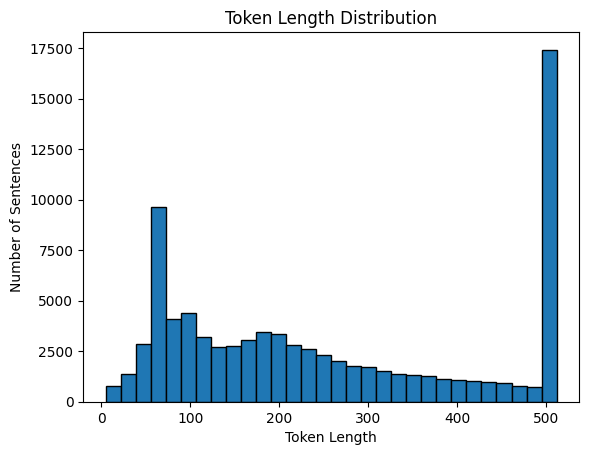

In [26]:
fig = plt.hist(token_lens, bins = 30, edgecolor = 'black')
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Number of Sentences')

In [28]:
# setup a tokenizer function for fine-tuning the BERT model
def TFtokenize(sentences, max_length):

    i = 0

    input_ids = []
    attn_masks = []

    for sentence in sentences:
        # Tokenize the sentence using the tokenizer
        # Use encode_plus to get the input IDs and attention mask
        # Use max_length to pad/truncate the sequences
        
        encoded_sentence = tokenizer.encode_plus(
            sentence,
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True)
        
        # print the results of tokenization for the first 5 sentences
        # to understand how it is working
        if i<5:
            print(sentence)
            print(encoded_sentence['input_ids'])
            print(encoded_sentence['attention_mask'])

        input_ids.append(encoded_sentence['input_ids'])
        attn_masks.append(encoded_sentence['attention_mask'])

        i += 1
        
    input_ids = tf.convert_to_tensor(input_ids)
    attn_masks = tf.convert_to_tensor(attn_masks)
    
    return input_ids, attn_masks

In [72]:
# setup a tokenizer function for fine-tuning the BERT model
def TFtokenize2(sentences, max_length):

    i = 0

    input_ids = []
    attn_masks = []

    for sentence in sentences:
        # Tokenize the sentence using the tokenizer
        # Use encode_plus to get the input IDs and attention mask
        # Use max_length to pad/truncate the sequences

        s = sentence.split()
        if len(s)>max_length-2:
            start = (max_length-2)//4
            end = (max_length-2)-start
            s = s[:start] + s[-end:]

        sentence = ' '.join(s)
        
        encoded_sentence = tokenizer.encode_plus(
            sentence,
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True)
        
        # print the results of tokenization for the first 5 sentences
        # to understand how it is working
        if i<5:
            print(sentence)
            print(encoded_sentence['input_ids'])
            print(encoded_sentence['attention_mask'])

        input_ids.append(encoded_sentence['input_ids'])
        attn_masks.append(encoded_sentence['attention_mask'])

        i += 1
        
    input_ids = tf.convert_to_tensor(input_ids)
    attn_masks = tf.convert_to_tensor(attn_masks)
    
    return input_ids, attn_masks

In [ ]:
# Tokenize the training and validation datasets for use in the model
train_input_ids, train_attn_masks = TFtokenize(X_train, 64)
dev_input_ids, dev_attn_masks = TFtokenize(X_test, 64)

billpayments paymentslistlight . p2p askmemberv2 . p2p loyaltyuserinfo . wealth getportfolioslist . billpayments commission . p2pmember getp2pmemberidbyactualuserid . categories get . masspayments deferredmassnofiles . wealth getportfolioslist . accounts accounts_full . userrole getapplicationroles . transactions commission . transactions commission . issuecredit getuserapplications . p2p configuration . billpayments commission . p2pmember getp2pmemberidbyactualuserid . categories get . masspayments deferredmassnofiles . wealth getportfolioslist . accounts accounts_full . userrole getapplicationroles . transactions paymentslist . usersdocuments getcustomerdetails . transactions series post . api logger logerror .
[101, 3021, 4502, 25219, 7666, 10504, 9863, 7138, 1012, 1052, 2475, 2361, 3198, 4168, 21784, 2615, 2475, 1012, 1052, 2475, 2361, 9721, 20330, 2378, 14876, 1012, 7177, 2131, 6442, 14876, 12798, 14540, 2923, 1012, 3021, 4502, 25219, 7666, 3222, 1012, 1052, 2475, 9737, 6633, 5677

In [ ]:
# convert the ground truth labels to a tensor for later use
train_labels = tf.convert_to_tensor(y_train)
dev_labels = tf.convert_to_tensor(y_test)

In [ ]:
# create initial model
model = TFDistilBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [31]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# set the hyperparameters for the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [ ]:
# set weight to compensate accuracy metric for class imbalance
class_0 = len(train_labels[train_labels==0])
class_1 = len(train_labels[train_labels==1])
weight_1 = class_0/class_1

In [34]:
# Train the model
history = model.fit([train_input_ids, train_attn_masks], train_labels, class_weight={0: 1, 1: weight_1}, batch_size=32, epochs=3, validation_data=([dev_input_ids, dev_attn_masks], dev_labels))

Epoch 1/3


I0000 00:00:1745030803.230163   28006 service.cc:152] XLA service 0x7f7275629580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745030803.230202   28006 service.cc:160]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2025-04-18 22:46:43.236846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745030803.251196   28006 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745030803.427369   28006 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2633/2633 [==============================] - 843s 312ms/step - loss: 1.5937 - accuracy: 0.6187 - val_loss: 0.5872 - val_accuracy: 0.9991
Epoch 2/3
2633/2633 [==============================] - 823s 313ms/step - loss: 1.5528 - accuracy: 0.6239 - val_loss: 1.1428 - val_accuracy: 9.4962e-04
Epoch 3/3
2633/2633 [==============================] - 824s 313ms/step - loss: 1.4696 - accuracy: 0.5381 - val_loss: 0.4034 - val_accuracy: 0.9991


In [37]:
y_pred = model.predict(dev_input_ids)

659/659 [==============================] - 68s 102ms/step


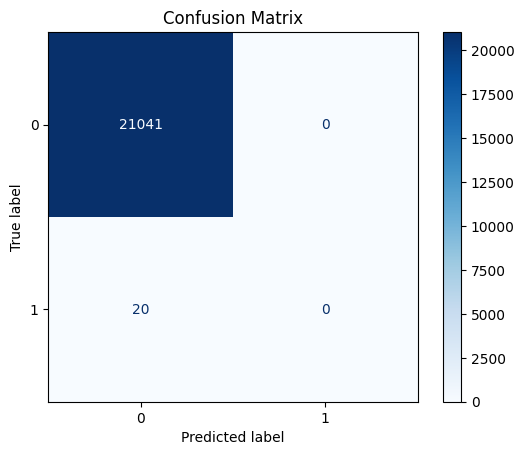

In [ ]:
cm = confusion_matrix(y_test, np.argmax(y_pred.logits, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

* due to the large class imbalance, this model performs extremely poorly with all fraudulent transactions being classified as valid
* an alternative approach to the simple class weights must be implemented to improve the results
* the next model will try undersampling AND class weights to try and improve the results

## Fine tune DistilBERT 2
* alternative settings to try and improve results
* use undersampled to reduce class imbalance to 10:1 ratio

In [95]:
# Tokenize the training and validation datasets for use in the model
train_input_ids2, train_attn_masks2 = TFtokenize2(X_train, 256)
dev_input_ids2, dev_attn_masks2 = TFtokenize2(X_test, 256)

campaign getcampaigns . cards fetchcards . categories get . p2pmember getp2pmemberidbyactualuserid . p2pregistration askmember . masspayments deferredmassnofiles . campaign getcampaigns . accounts accounts_full . account login . cards fetchcards . userrole getapplicationroles . transactions series post . api logger logerror .
[101, 3049, 2131, 26468, 4886, 16206, 2015, 1012, 5329, 18584, 17965, 1012, 7236, 2131, 1012, 1052, 2475, 9737, 6633, 5677, 2131, 2361, 2475, 9737, 6633, 5677, 3593, 3762, 18908, 8787, 20330, 3593, 1012, 1052, 2475, 28139, 24063, 8156, 3198, 4168, 21784, 1012, 3742, 4502, 25219, 7666, 13366, 28849, 22117, 12054, 3630, 8873, 4244, 1012, 3049, 2131, 26468, 4886, 16206, 2015, 1012, 6115, 6115, 1035, 2440, 1012, 4070, 8833, 2378, 1012, 5329, 18584, 17965, 1012, 5310, 13153, 2063, 2131, 29098, 19341, 3508, 13153, 2229, 1012, 11817, 2186, 2695, 1012, 17928, 8833, 4590, 8833, 2121, 29165, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# randomly select 800 valid transactions from training dataset
train_input_ids3 = tf.random.shuffle(tf.boolean_mask(train_input_ids2, ~train_labels))[0:800]

# add back in fraudulent transactions
train_input_ids3 = tf.concat([train_input_ids3, tf.boolean_mask(train_input_ids2, train_labels)], 0)

# recreate ground truth labels for new undersampled dataset
labels3 = tf.convert_to_tensor([0 if i<800 else 1 for i in range(881)])

# shuffle the undersampled dataset to randomize it
indices = tf.range(start=0, limit=tf.shape(train_input_ids3)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

train_input_ids3 = tf.gather(train_input_ids3, shuffled_indices)
labels3 = tf.gather(labels3, shuffled_indices)

train_attn_masks3 = train_input_ids3/train_input_ids3
train_attn_masks3 = tf.cast(tf.where(tf.math.is_nan(train_attn_masks3), tf.zeros_like(train_attn_masks3), train_attn_masks3), dtype=tf.int32)

In [ ]:
# create new model for training
model3 = TFDistilBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [103]:
# set the hyperparameters for the model
loss3 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics3 = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# metrics = tf.keras.metrics.F1Score(name='f1_score')
optimizer3 = tf.keras.optimizers.Adam(learning_rate=5e-5) #, epsilon=1e-08)

model3.compile(optimizer=optimizer3, loss=loss3, metrics=[metrics3])

In [ ]:
# train model on undersampled dataset
history3 = model3.fit([train_input_ids3, train_attn_masks3], labels3, class_weight={0: 1, 1: 10}, batch_size=16, epochs=5, validation_data=([dev_input_ids2, dev_attn_masks2], dev_labels))

Epoch 1/5


56/56 [==============================] - 293s 5s/step - loss: 1.2842 - accuracy: 0.6413 - val_loss: 0.6523 - val_accuracy: 0.7689
Epoch 2/5
56/56 [==============================] - 274s 5s/step - loss: 1.2154 - accuracy: 0.5380 - val_loss: 0.7383 - val_accuracy: 0.2164
Epoch 3/5
56/56 [==============================] - 276s 5s/step - loss: 1.0389 - accuracy: 0.7185 - val_loss: 0.6000 - val_accuracy: 0.5377
Epoch 4/5
56/56 [==============================] - 275s 5s/step - loss: 0.8905 - accuracy: 0.6788 - val_loss: 0.7792 - val_accuracy: 0.5198
Epoch 5/5
56/56 [==============================] - 276s 5s/step - loss: 0.7955 - accuracy: 0.6947 - val_loss: 0.3929 - val_accuracy: 0.7987


In [ ]:
# predict the results on the testing dataset
y_pred3 = model3.predict(dev_input_ids2)

659/659 [==============================] - 222s 333ms/step


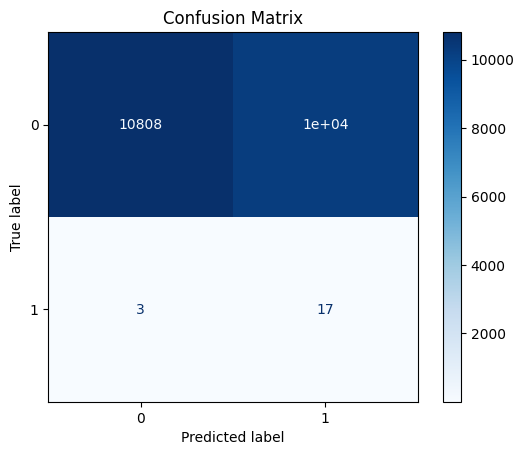

In [ ]:
# plot the confusion matrix to quantify model performance
cm3 = confusion_matrix(y_test, np.argmax(y_pred3.logits, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [109]:
model3.save_pretrained('./distilbert_saved/')

In [ ]:
# validate reloading model
new_model = TFDistilBertForSequenceClassification.from_pretrained('./distilbert_saved')
new_y_pred = new_model.predict(dev_input_ids2)

new_cm = confusion_matrix(y_test, np.argmax(new_y_pred.logits, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=new_cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Some layers from the model checkpoint at ./distilbert_saved were not used when initializing TFDistilBertForSequenceClassification: ['dropout_99']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert_saved and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512/659 [======================>.......] - ETA: 50s

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [ ]:
# TODO: Add Code

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [ ]:
# TODO: Add code

### Issues / Improvements
1. Significant class imbalance - alternative methods to combat this may improve results
2. Data is not traditional natural language. API endpoints could be encoded differently to help with binary classification
3. Fraud class is very small. More data would result in a more robust model.
4. A custom model instead of a pretrained model may be more accurate if enough data is available
5. Ensemble methods to mix in numerical data from the transactions would likely improve the results

###  References
   - Academic (if any)
   - Online (if any)
	

### Credits

- If you use and/or adapt your code from existing projects, you must provide links and acknowldge the authors. Keep in mind that all documents in your projects and code will be check against the official plagiarism detection tool used by Penn State ([Turnitin](https://turnitin.psu.edu))

> *This code is based on .... (if any)*